# Overview
The goal is to accurately predict music genres of songs based on the dataset provided by the Spotify API. We can explore different ways to acheive this.

## Supervised Learning
Given we have the labels, we can approach this problem through a supervised learning technique. 

## Unsupervised Learning
However, given our dataset has missing values, we may need to approach handling the missing data with unsupervised learning techniques. Something that comes to mind before any code is written is PCA for linear dimensionality reduction and autoencoders for unsupervised network models.

But first...

In [1]:
import random
random.seed(14173755)

In [2]:
# import root path to use models and preprocessing-pipeline
import sys
sys.path.append(".")

# we'll import our necessary dependancies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
import torch
from torch import nn
from torch import optim

# import dimensionality reduction
from sklearn.manifold import TSNE

# import our pipeline modules and models
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from data_pipeline import SongData

# import clustering methods (KMeans)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# import neighbors for tuning dbscan
from sklearn.neighbors import NearestNeighbors

# import our implemented models
from models import pca, compute_covariance, project_pc, FNN

# import metrics to measure nn performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, RocCurveDisplay, PrecisionRecallDisplay

In [3]:
# let's get the data
data = pd.read_csv('./musicData.csv')
df = pd.DataFrame(data = data)

df.head(n = 10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.614,Electronic
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,4-Apr,0.230,Electronic
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,4-Apr,0.761,Electronic
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,4-Apr,0.273,Electronic
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,4-Apr,0.203,Electronic


Now that we have our data in a dataframe, we can look at a very small sample of it so that way we can in what ways we should manipluate the data.

In [4]:
# check for any na
print('Check for NaN')
print(df.isna().sum())
print(df[df.isna().all(axis=1)])  # rows with all NaNs
print(df.loc[:, df.isna().all(axis=0)])  # columns with all NaNs

df = df.dropna(how='all')  # or 'all' if whole rows are missing

print('Confirm NaN is removed')
print(df.isna().sum())
print(df[df.isna().all(axis=1)])  # rows with all NaNs
print(df.loc[:, df.isna().all(axis=0)])  # columns with all NaNs

X = df.drop(columns = ['music_genre', 'track_name', 'instance_id', 'artist_name', 'obtained_date'])
y = df['music_genre']

artist_name = df['artist_name']

X.head(n = 10)

Check for NaN
instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64
       instance_id artist_name track_name  popularity  acousticness  \
10000          NaN         NaN        NaN         NaN           NaN   
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10000           NaN          NaN     NaN               NaN  NaN       NaN

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,0.759
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,0.531
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,0.333
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,0.270
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,0.323
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,0.614
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,0.230
7,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,0.761
8,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,0.273
9,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,0.203


In [5]:
y.head(n = 10)

0    Electronic
1    Electronic
2    Electronic
3    Electronic
4    Electronic
5    Electronic
6    Electronic
7    Electronic
8    Electronic
9    Electronic
Name: music_genre, dtype: object

In [6]:
# now, let's check which features have missing data. insight will be helpful for data imputation
isMissing = df.isnull()
print(f'Fields where data is NaN:\n\n {isMissing.sum()}')

Fields where data is NaN:

 instance_id         0
artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64


We can see that each feature is missing data. We'll address this with exploratory data analysis.

<hr>

### Clean up a bit more and calculate means of each feature

In [7]:
X.head(n = 10)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,0.759
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,0.531
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,0.333
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,0.270
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,0.323
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,0.614
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,0.230
7,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,0.761
8,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,0.273
9,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,0.203


In [8]:
# drop all rows and cols of dataset where df[m, n] = NaN
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
df_rows = X.dropna()
df_copy = X.dropna(axis = 1)

print(f'Types of X: {X.dtypes}')

# notice the ? in tempo ??
X['tempo'] = pd.to_numeric(df['tempo'], errors='coerce') # this will change any numeric values to ?
X['tempo'].fillna(X['tempo'].mean(), inplace=True)  # or use median, interpolation, etc.

# one-hot encode mode feature
X['mode'] = X['mode'].map({'Major': 1, 'Minor': 0})

# encode key feature categorically
X['key'] = pd.Categorical(X['key']).codes

isMissing_copy = df_copy.isnull()
print(f'Fields where data is NaN:')
print(isMissing_copy.sum())

Shape of X: (50000, 13)
Shape of y: (50000,)
Types of X: popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
dtype: object
Fields where data is NaN:
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
dtype: int64


We can visualize each feature, plotting against the label.

In [9]:
# let's get the number music genres that are in the dataset
# let's test our class now
song_data = SongData(X, y)

labels, numLabels, label_count = song_data.labelExtraction(y)

print(f'Number of Labels: {numLabels}')
print()
print(f'Labels:')
for i in range(len(labels)):
    print(f'Label {i + 1}: {labels[i]}')
print()
print(f'Count of Labels: {label_count}')

Number of Labels: 10

Labels:
Label 1: Alternative
Label 2: Hip-Hop
Label 3: Electronic
Label 4: Rap
Label 5: Anime
Label 6: Jazz
Label 7: Country
Label 8: Classical
Label 9: Rock
Label 10: Blues

Count of Labels: {'Alternative': 5000, 'Hip-Hop': 5000, 'Electronic': 5000, 'Rap': 5000, 'Anime': 5000, 'Jazz': 5000, 'Country': 5000, 'Classical': 5000, 'Rock': 5000, 'Blues': 5000}


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


In [10]:
X_copy = X
y_copy = y
print(f'Shape of X: {X_copy.shape}')

# print type of each feature
print('Type of each feature:\n', X_copy.dtypes)

X_copy.head(n = 10)

Shape of X: (50000, 13)
Type of each feature:
 popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                    int8
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
valence             float64
dtype: object


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,27.0,0.00468,0.652,-1.0,0.941,0.792000,1,0.1150,-5.201,0,0.0748,100.889000,0.759
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,5,0.1240,-7.043,0,0.0300,115.002000,0.531
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,11,0.5340,-4.617,1,0.0345,127.994000,0.333
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,4,0.1570,-4.498,1,0.2390,128.014000,0.270
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,9,0.1570,-6.266,1,0.0413,145.036000,0.323
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,5,0.2160,-10.517,0,0.0412,119.952961,0.614
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,2,0.1060,-4.294,1,0.3510,149.995000,0.230
7,43.0,0.02970,0.809,416132.0,0.706,0.903000,10,0.0635,-9.339,0,0.0484,120.008000,0.761
8,39.0,0.00299,0.509,292800.0,0.921,0.000276,8,0.1780,-3.175,0,0.2680,149.948000,0.273
9,22.0,0.00934,0.578,204800.0,0.731,0.011200,0,0.1110,-7.091,0,0.1730,139.933000,0.203


In [11]:
y_copy.head(n = 10)

0    Electronic
1    Electronic
2    Electronic
3    Electronic
4    Electronic
5    Electronic
6    Electronic
7    Electronic
8    Electronic
9    Electronic
Name: music_genre, dtype: object

Here is what we'll do:

    1. Compute correlation coefficients
    2. Plot scatters to determine which/if all features should be normalized
    3. Perform different dimensionality reduction methods + cluster

This is all part of the preprocessing prior to actually using an model on the data.

In [12]:
# compute correlation coefficients
corr_ag_labels = X_copy.corr()
corr_collinear = X_copy.corr()

# print correlation against labels
corr_ag_labels.head(n = len(corr_ag_labels.columns))

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
popularity,1.000000,-0.290453,0.356420,-0.083809,0.216345,-0.364960,-0.005212,-0.039468,0.317941,-0.013427,0.224309,0.031188,0.124913
acousticness,-0.290453,1.000000,-0.347681,0.061862,-0.791250,0.387970,0.005796,-0.109220,-0.730401,0.025161,-0.163377,-0.220800,-0.270238
danceability,0.356420,-0.347681,1.000000,-0.155507,0.263934,-0.301277,-0.017777,-0.051465,0.390859,-0.049634,0.279767,-0.014464,0.434557
duration_ms,-0.083809,0.061862,-0.155507,1.000000,-0.066203,0.129738,-0.004293,0.019911,-0.102509,-0.014042,-0.083636,-0.038329,-0.130574
energy,0.216345,-0.791250,0.263934,-0.066203,1.000000,-0.389730,-0.001546,0.186731,0.838399,-0.017878,0.158180,0.248436,0.396317
instrumentalness,-0.364960,0.387970,-0.301277,0.129738,-0.389730,1.000000,0.000263,-0.093537,-0.529030,-0.060924,-0.199137,-0.120318,-0.272780
key,-0.005212,0.005796,-0.017777,-0.004293,-0.001546,0.000263,1.000000,-0.001112,-0.003095,0.057697,-0.012535,-0.005294,-0.000466
liveness,-0.039468,-0.109220,-0.051465,0.019911,0.186731,-0.093537,-0.001112,1.000000,0.126504,0.013550,0.114475,0.037671,0.052110
loudness,0.317941,-0.730401,0.390859,-0.102509,0.838399,-0.529030,-0.003095,0.126504,1.000000,-0.008744,0.165578,0.226885,0.340664
mode,-0.013427,0.025161,-0.049634,-0.014042,-0.017878,-0.060924,0.057697,0.013550,-0.008744,1.000000,-0.077379,0.018641,0.025427


We can see there is some correlation between a few features, making this a good candidate for dimensionality reduction

In [13]:
# let's see the means of the features and then standardize the matrix
print(X_copy.mean())

popularity              44.220420
acousticness             0.306383
danceability             0.558241
duration_ms         221252.602860
energy                   0.599755
instrumentalness         0.181601
key                      5.354420
liveness                 0.193896
loudness                -9.133761
mode                     0.641980
speechiness              0.093586
tempo                  119.952961
valence                  0.456264
dtype: float64


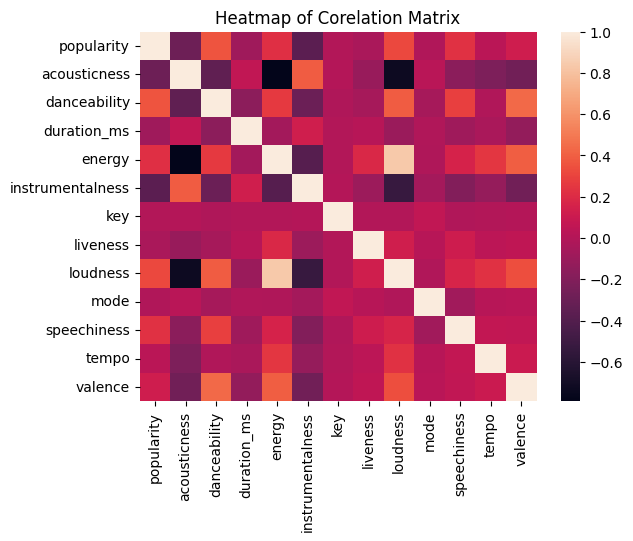

In [14]:
ax = plt.axes()
sns.heatmap(corr_ag_labels)

ax.set_title('Heatmap of Corelation Matrix')
plt.show()

In [15]:
# convert to np arrays and we'll use this for comptuation from here on out
X_true = song_data.transformToNP(X_copy)
y_true = song_data.transformToNP(y_copy)

print('Type of X_true:', type(X_true))
print('Type of y_true:', type(y_true))

# print type of each feature to double check
for feature in range(0, X_true.shape[1]):
    print(f'Type of {X_copy.columns[feature]}: {X_true.dtype}')

Type of X_true: <class 'numpy.ndarray'>
Type of y_true: <class 'numpy.ndarray'>
Type of popularity: float64
Type of acousticness: float64
Type of danceability: float64
Type of duration_ms: float64
Type of energy: float64
Type of instrumentalness: float64
Type of key: float64
Type of liveness: float64
Type of loudness: float64
Type of mode: float64
Type of speechiness: float64
Type of tempo: float64
Type of valence: float64


In [16]:
# let's also check to make sure we copied the correct data
print('X:', X_true)
print('y:', y_true)

X: [[2.70000e+01 4.68000e-03 6.52000e-01 ... 7.48000e-02 1.00889e+02
  7.59000e-01]
 [3.10000e+01 1.27000e-02 6.22000e-01 ... 3.00000e-02 1.15002e+02
  5.31000e-01]
 [2.80000e+01 3.06000e-03 6.20000e-01 ... 3.45000e-02 1.27994e+02
  3.33000e-01]
 ...
 [5.10000e+01 5.97000e-03 6.93000e-01 ... 1.46000e-01 1.31079e+02
  3.95000e-01]
 [6.50000e+01 8.31000e-02 7.82000e-01 ... 4.41000e-02 7.58860e+01
  3.54000e-01]
 [6.70000e+01 1.02000e-01 8.62000e-01 ... 1.01000e-01 9.92010e+01
  7.65000e-01]]
y: ['Electronic' 'Electronic' 'Electronic' ... 'Hip-Hop' 'Hip-Hop' 'Hip-Hop']


## Dimensionality Reduction 
<hr>
We'll Perform standard dimensionality reduction on this dataset. We can see that there isn't much linear dependence amongst the features, but that doesn't take into account any possible non-linear dependencies. We will be able to find these and reduce the input size with PCA and t-SNE.

Mean of popularity feature: 1.318767317570746e-16
Std of popularity feature: 1.0000000000000002

Mean of acousticness feature: 1.318767317570746e-16
Std of acousticness feature: 1.0000000000000002

Mean of danceability feature: 1.318767317570746e-16
Std of danceability feature: 1.0000000000000002

Mean of duration_ms feature: 1.318767317570746e-16
Std of duration_ms feature: 1.0000000000000002

Mean of energy feature: 1.318767317570746e-16
Std of energy feature: 1.0000000000000002

Mean of instrumentalness feature: 1.318767317570746e-16
Std of instrumentalness feature: 1.0000000000000002

Mean of key feature: 1.318767317570746e-16
Std of key feature: 1.0000000000000002

Mean of liveness feature: 1.318767317570746e-16
Std of liveness feature: 1.0000000000000002

Mean of loudness feature: 1.318767317570746e-16
Std of loudness feature: 1.0000000000000002

Mean of mode feature: 1.318767317570746e-16
Std of mode feature: 1.0000000000000002

Mean of speechiness feature: 1.318767317570746e-16

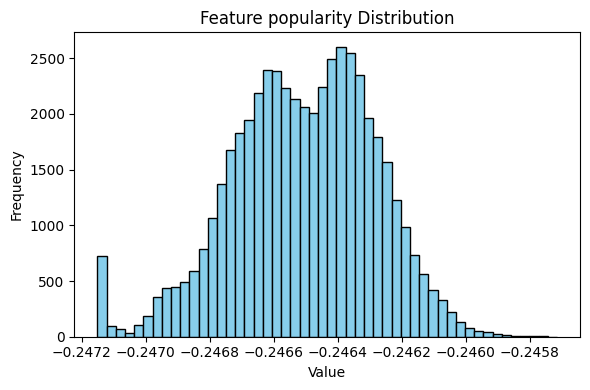

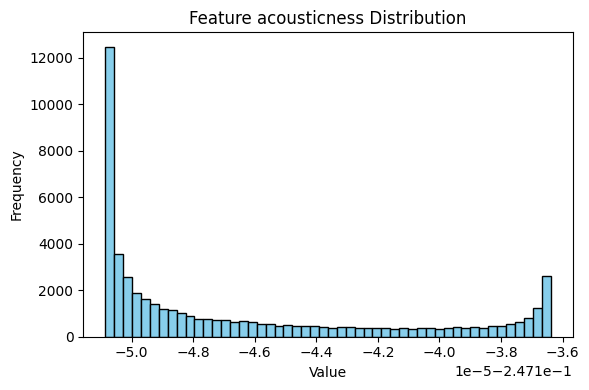

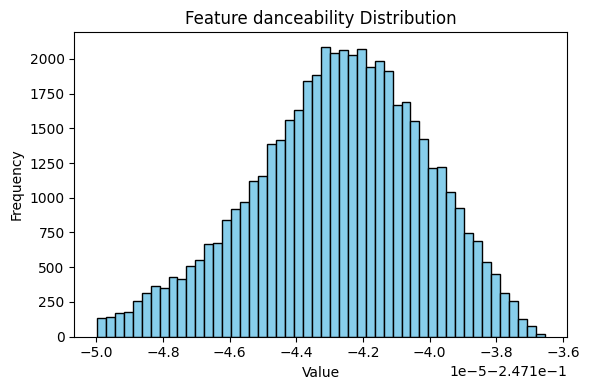

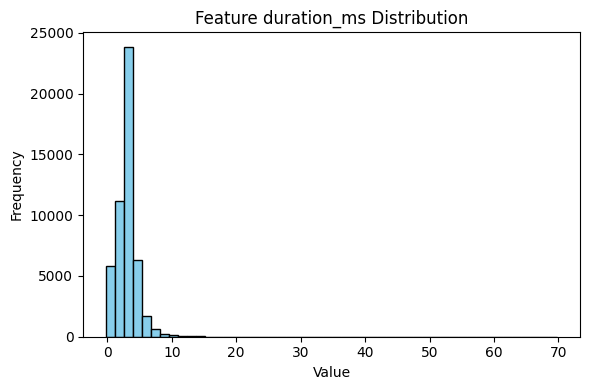

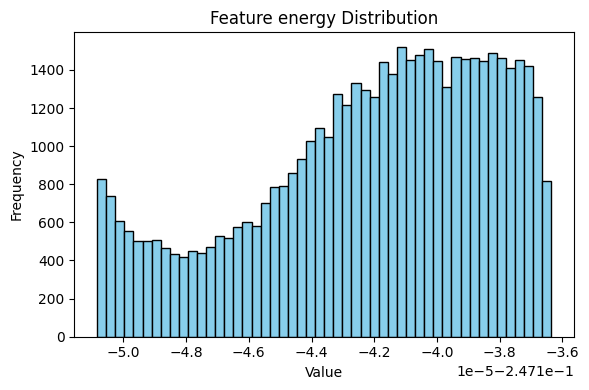

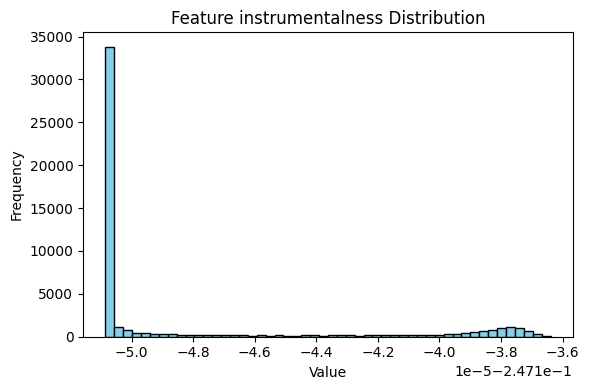

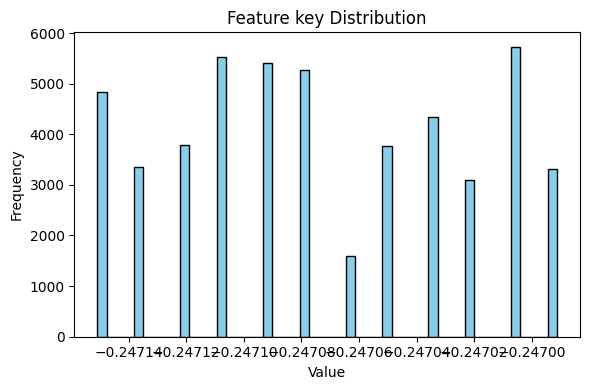

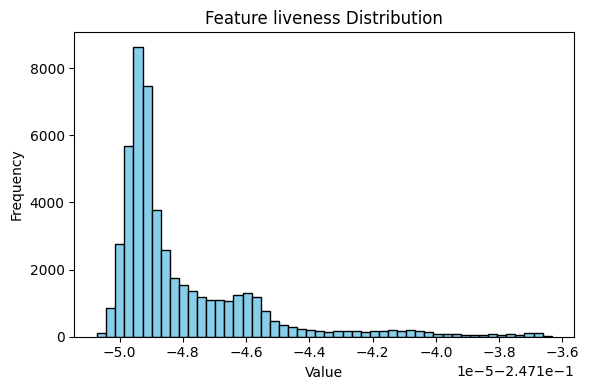

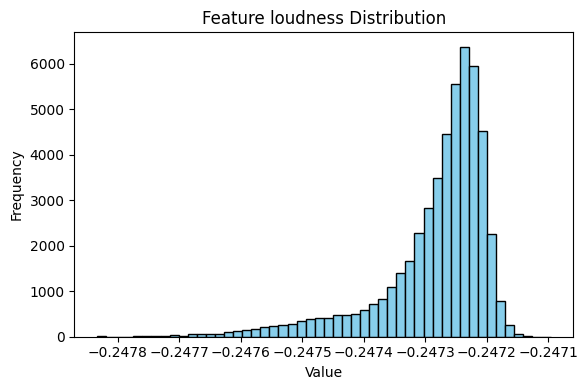

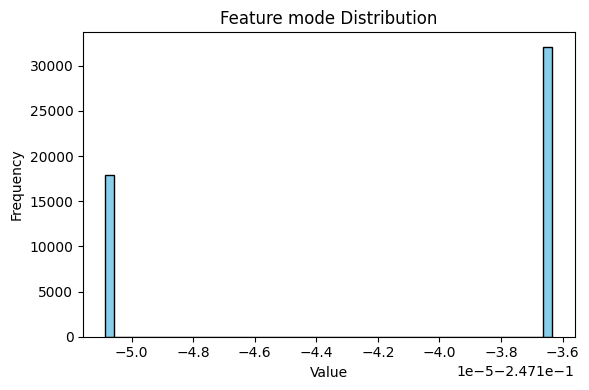

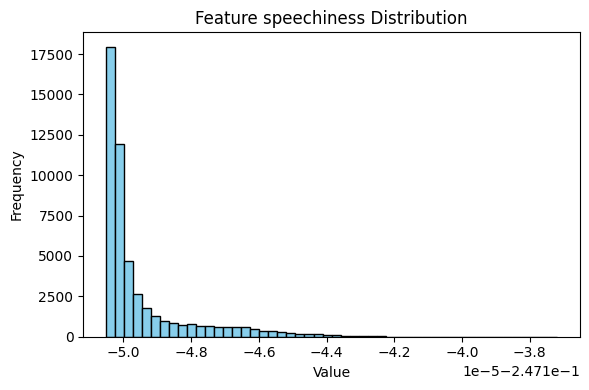

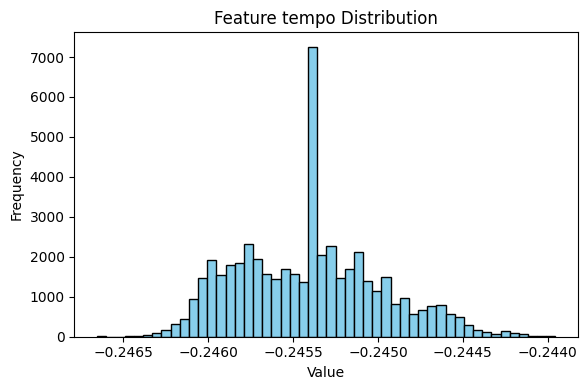

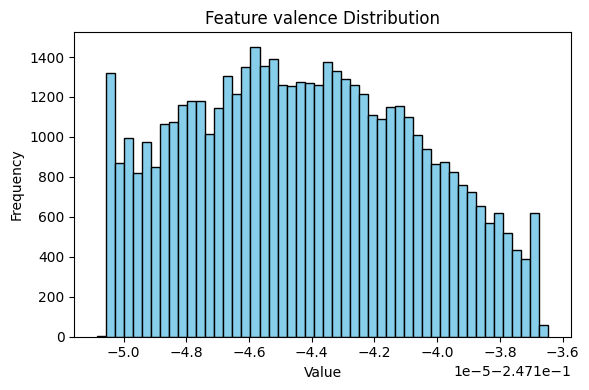

In [17]:
# let's standardize our input
X_standardized = song_data.z_score(X_true)

# check means and std
for feature in range(0, X_standardized.shape[1]):
    print(f'Mean of {X.columns[feature]} feature: {np.mean(X_standardized)}')
    print(f'Std of {X.columns[feature]} feature: {np.std(X_standardized)}')
    print()

for feature in range(X_standardized.shape[1]):
    plt.figure(figsize=(6, 4))
    plt.hist(X_standardized[:, feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Feature {X_copy.columns[feature]} Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [18]:
X_scaled = StandardScaler().fit_transform(X_true)

Looking at the heatmap, we see there is essentially no covariance dependence upon the features. This dataset is not that suitable for PCA

<Axes: >

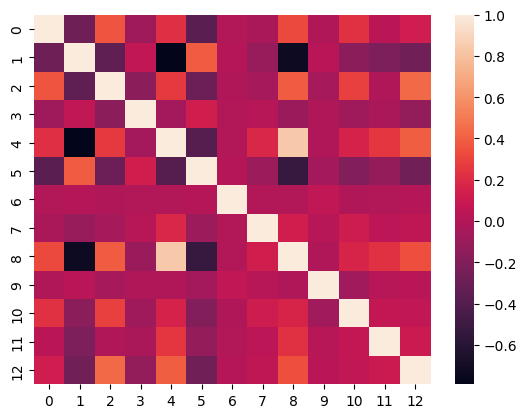

In [19]:
cov = compute_covariance(X_scaled)

# plot the heatmap
sns.heatmap(cov)

Num principal components: 3
Shape of PCA projection: (50000, 3)


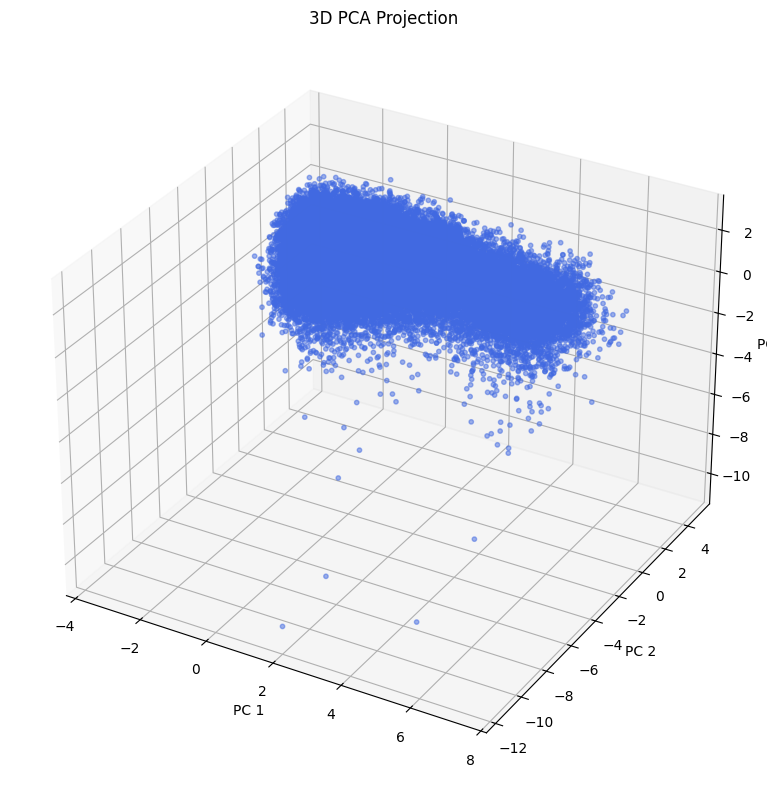

In [20]:
# run PCA
n_components, explained_var, eigenvalues, eigenvectors = pca(cov)
print('Num principal components:', n_components)

principal_components = eigenvectors[:, :n_components]
# project the principal components onto the dataset
X_pca = project_pc(X_scaled, principal_components)
print('Shape of PCA projection:', X_pca.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# plot 3d scatter of the data
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.5, s=10, c='royalblue')
ax.set_title('3D PCA Projection')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.tight_layout()
plt.show()

Let's also reduce the dataset with t-SNE to evaluate our clustering algorithms on

In [21]:
'''
kl_divergence = list()

tsne =  TSNE(
    n_components = n_components,
    perplexity = 30,
    n_jobs = 1
)

X_embedded = tsne.fit_transform(X_scaled)

kl_divergence.append(tsne.kl_divergence_)
print(f'Shape of Embedded X: {X_embedded.shape}')

# plot the reduction
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c='blue', marker='o')
ax.set_title(f't-SNE (Perplexity=30, KL = {tsne.kl_divergence_:.4f})')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()
'''

"\nkl_divergence = list()\n\ntsne =  TSNE(\n    n_components = n_components,\n    perplexity = 30,\n    n_jobs = 1\n)\n\nX_embedded = tsne.fit_transform(X_scaled)\n\nkl_divergence.append(tsne.kl_divergence_)\nprint(f'Shape of Embedded X: {X_embedded.shape}')\n\n# plot the reduction\nfig = plt.figure(figsize=(10, 6))\nax = fig.add_subplot(111, projection='3d')\nax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c='blue', marker='o')\nax.set_title(f't-SNE (Perplexity=30, KL = {tsne.kl_divergence_:.4f})')\nax.set_xlabel('t-SNE Component 1')\nax.set_ylabel('t-SNE Component 2')\nax.set_zlabel('t-SNE Component 3')\nplt.show()\n"

Now, we'll use kmeans++ (Lloyd's algorithm) to help us find the number of clusters. This will help the model tremendously during training

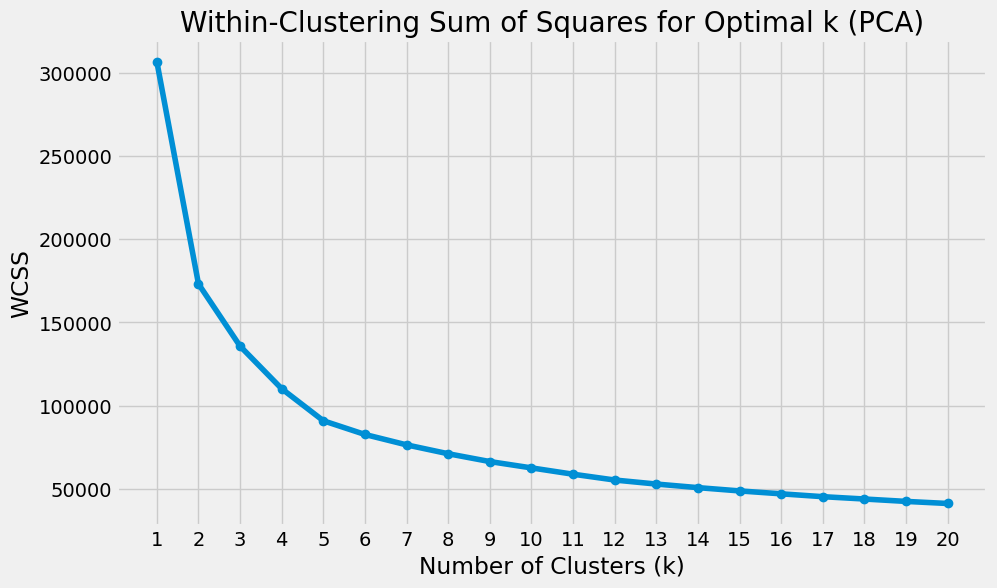

In [22]:
# we'll use within-cluster sum of squares to determine optimal # of clusters/k-value
wcss_pca = []
max_k = 20  # test up to 20 clusters
for k in range(1, max_k + 1):
    kmeans_pca = KMeans(n_clusters = k, init = 'k-means++', random_state = 42, n_init = 10)
    kmeans_pca.fit(X_pca)
    labels_pca = kmeans_pca.fit_predict(X_pca)
    wcss_pca.append(kmeans_pca.inertia_)
    centroids_pca = kmeans_pca.cluster_centers_

# plot the elbow
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize = (10, 6))
    plt.plot(range(1, max_k + 1), wcss_pca, marker = 'o')
    plt.title('Within-Clustering Sum of Squares for Optimal k (PCA)', fontsize = 20)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.xticks(range(1, max_k + 1))
    plt.show()

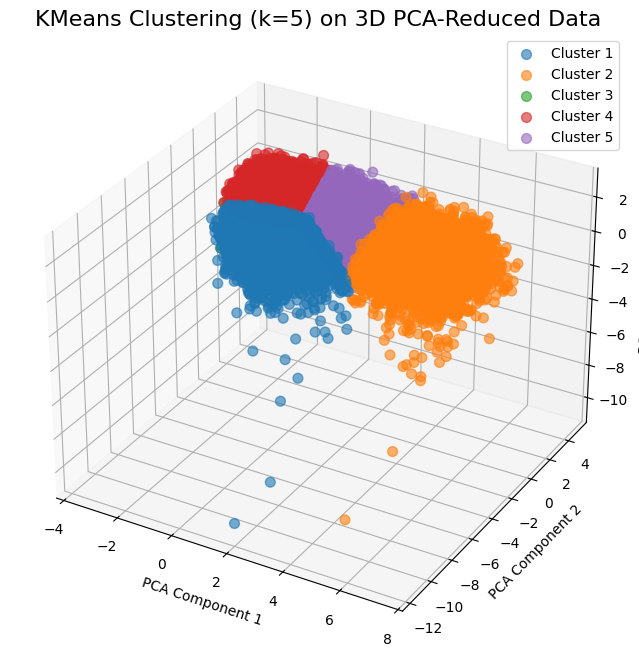

In [23]:
# plot the cluster with our known k
k = 5
kmeans_pca = KMeans(n_clusters = k, init = 'k-means++', random_state = 42, n_init = 10)
kmeans_pca.fit(X_pca)
labels_pca = kmeans_pca.fit_predict(X_pca)
wcss_pca.append(kmeans_pca.inertia_)
centroids_pca = kmeans_pca.cluster_centers_

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(5):
    ax.scatter(
        X_pca[labels_pca == i, 0],
        X_pca[labels_pca == i, 1],
        X_pca[labels_pca == i, 2],
        label=f'Cluster {i + 1}',
        s=50, alpha=0.6
    )

ax.set_title('KMeans Clustering (k=5) on 3D PCA-Reduced Data', fontsize=16)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()

We'll also cluster with DBSCAN to see the difference between the data

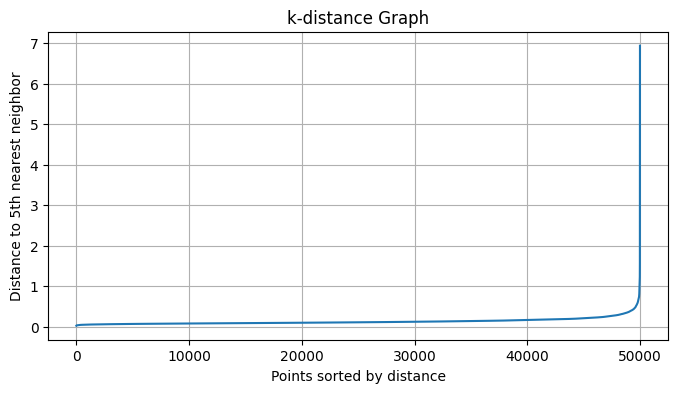

In [24]:
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("k-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.grid(True)
plt.show()

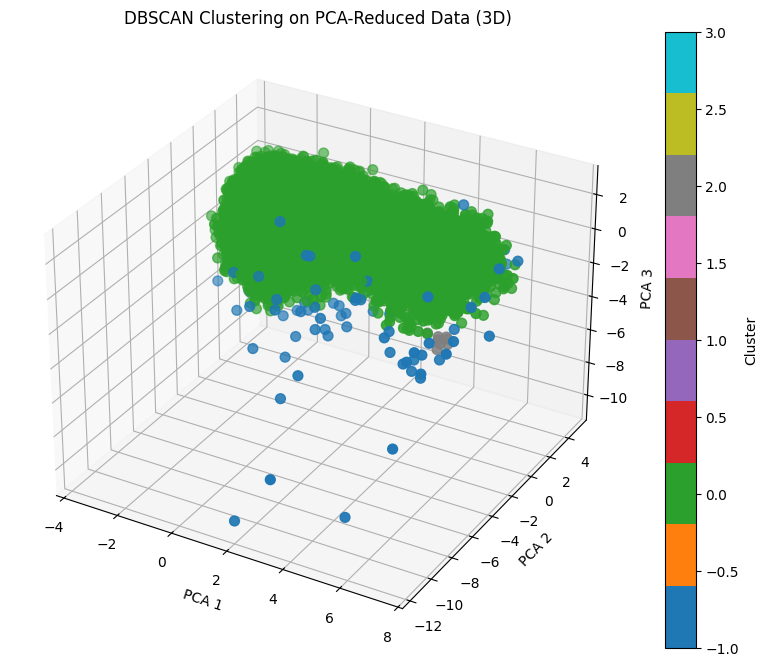

In [25]:
db = DBSCAN(eps=0.55, min_samples=k)
labels_db = db.fit_predict(X_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Color by cluster label
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=labels_db, cmap='tab10', s=50
)

ax.set_title("DBSCAN Clustering on PCA-Reduced Data (3D)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.colorbar(scatter, label='Cluster')
plt.show()

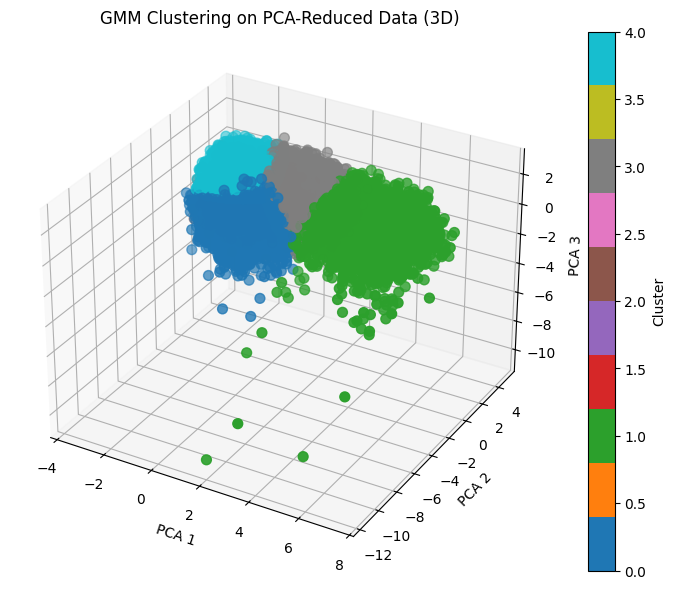

In [26]:
# Assume X_pca has 3 components already
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

# 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=gmm_labels, cmap='tab10', s=50
)

ax.set_title("GMM Clustering on PCA-Reduced Data (3D)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.colorbar(scatter, label='Cluster')
plt.show()

Here, we can see that the GMM model performs very nicely and clusters a lot better than DBSCAN on the reduced dataset. Knowing we got a less clusters that actually predicted, the data might have shown that we actually have some correlation between the data than we initially thought we had. 

Let's add the cluster labels to the dataset and train a deep model on this data to see how accurate we can get.

In [27]:
# add the cluster labels to the original dataset
X['clusters'] = labels_pca
    
X.head(n=10)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,clusters
0,27.0,0.00468,0.652,-1.0,0.941,0.792000,1,0.1150,-5.201,0,0.0748,100.889000,0.759,2
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,5,0.1240,-7.043,0,0.0300,115.002000,0.531,0
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,11,0.5340,-4.617,1,0.0345,127.994000,0.333,0
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,4,0.1570,-4.498,1,0.2390,128.014000,0.270,2
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,9,0.1570,-6.266,1,0.0413,145.036000,0.323,4
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,5,0.2160,-10.517,0,0.0412,119.952961,0.614,0
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,2,0.1060,-4.294,1,0.3510,149.995000,0.230,2
7,43.0,0.02970,0.809,416132.0,0.706,0.903000,10,0.0635,-9.339,0,0.0484,120.008000,0.761,3
8,39.0,0.00299,0.509,292800.0,0.921,0.000276,8,0.1780,-3.175,0,0.2680,149.948000,0.273,0
9,22.0,0.00934,0.578,204800.0,0.731,0.011200,0,0.1110,-7.091,0,0.1730,139.933000,0.203,0


In [28]:
# let's just explore the mean of the clusters (for exploratory purposes)
print('mean of clusters feature:', X['clusters'].mean())
print('std of clusters feature:', X['clusters'].std())

mean of clusters feature: 2.11482
std of clusters feature: 1.4082031204057914


Let's keep our input matrix consistent and normalize the data here as well

In [29]:
clusters_normalized = song_data.z_score(X['clusters'])
print('mean of normalized clusters:', np.mean(clusters_normalized))
print('std of normalized clusters:', np.std(clusters_normalized))

mean of normalized clusters: 6.416200903913705e-17
std of normalized clusters: 1.0


In [30]:
# ensure clusters_normalized is a column vector
clusters_normalized = clusters_normalized.reshape(-1, 1)

# append to the original array
X_true = np.hstack((X, clusters_normalized))

print('X_true:', X)
print('Shape of X_true:', X_true.shape)

X_true:        popularity  acousticness  danceability  duration_ms  energy  \
0            27.0       0.00468         0.652         -1.0   0.941   
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
...           ...           ...           ...          ...     ...   
50000        59.0       0.03340         0.913         -1.0   0.574   
50001        72.0       0.15700         0.709     251860.0   0.362   
50002        51.0       0.00597         0.693     189483.0   0.763   
50003        65.0       0.08310         0.782     262773.0   0.472   
50004        67.0       0.10200         0.862     267267.0   0.642   

       instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0               0.79200    1     0.115    -5.201     0       0.0748  10

Let's run our feed-forward neural network on this data now

In [31]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_true)

print(y_encoded)

[5 5 5 ... 6 6 6]


In [32]:
# split the dataset using our train test split function
X_train, X_test, y_train, y_test = song_data.split_data(X, y_encoded)

# convert to tensors for pytorch
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.long)
y_test_tensor = torch.tensor(y_test, dtype = torch.long)

In [33]:
print('X Train', X_train_tensor)
print('X Test', X_test_tensor)
print('y train', y_train_tensor)
print('y test', y_test_tensor)

print('X train shape:', X_train_tensor.shape)
print('X test shape:', X_test_tensor.shape)
print('label train shape:', y_train_tensor.shape)
print('label test shape:', y_test_tensor.shape)

X Train tensor([[5.4000e+01, 1.0800e-04, 5.2400e-01,  ..., 1.6196e+02, 6.5900e-01,
         3.0000e+00],
        [6.7000e+01, 5.6100e-03, 7.7300e-01,  ..., 1.5598e+02, 5.8800e-02,
         2.0000e+00],
        [4.6000e+01, 8.7300e-05, 5.4100e-01,  ..., 1.3497e+02, 1.6400e-01,
         0.0000e+00],
        ...,
        [6.6000e+01, 9.2000e-01, 3.2500e-01,  ..., 1.4712e+02, 4.4700e-01,
         4.0000e+00],
        [6.1000e+01, 7.3100e-04, 5.2700e-01,  ..., 1.0220e+02, 2.2800e-01,
         0.0000e+00],
        [6.5000e+01, 4.3000e-01, 7.3500e-01,  ..., 1.2329e+02, 9.6700e-01,
         3.0000e+00]])
X Test tensor([[4.9000e+01, 2.2000e-01, 6.0200e-01,  ..., 1.7411e+02, 7.3300e-01,
         0.0000e+00],
        [5.2000e+01, 1.1600e-02, 9.0900e-01,  ..., 1.1982e+02, 5.7600e-01,
         3.0000e+00],
        [5.5000e+01, 5.9100e-03, 1.5200e-01,  ..., 7.5020e+01, 1.6200e-01,
         0.0000e+00],
        ...,
        [5.3000e+01, 4.4300e-01, 6.9700e-01,  ..., 8.6024e+01, 7.5300e-01,
         3

In [34]:
fnn = FNN(X_train_tensor, y_train_tensor, X_train_tensor.shape[1], numLabels)

fnn._train(X_train_tensor, y_train_tensor)

Epoch [1/200], Avg Loss: 27.3792
Epoch [2/200], Avg Loss: 2.3364
Epoch [3/200], Avg Loss: 2.3116
Epoch [4/200], Avg Loss: 2.2860
Epoch [5/200], Avg Loss: 2.2656
Epoch [6/200], Avg Loss: 2.2597
Epoch [7/200], Avg Loss: 2.2576
Epoch [8/200], Avg Loss: 2.2533
Epoch [9/200], Avg Loss: 2.2510
Epoch [10/200], Avg Loss: 2.2484
Epoch [11/200], Avg Loss: 2.2628
Epoch [12/200], Avg Loss: 2.2717
Epoch [13/200], Avg Loss: 2.2414
Epoch [14/200], Avg Loss: 2.2714
Epoch [15/200], Avg Loss: 2.2567
Epoch [16/200], Avg Loss: 2.2389
Epoch [17/200], Avg Loss: 2.2375
Epoch [18/200], Avg Loss: 2.2358
Epoch [19/200], Avg Loss: 2.2384
Epoch [20/200], Avg Loss: 2.2336
Epoch [21/200], Avg Loss: 2.2429
Epoch [22/200], Avg Loss: 2.2334
Epoch [23/200], Avg Loss: 2.2334
Epoch [24/200], Avg Loss: 2.2409
Epoch [25/200], Avg Loss: 2.2430
Epoch [26/200], Avg Loss: 2.2295
Epoch [27/200], Avg Loss: 2.2826
Epoch [28/200], Avg Loss: 2.2358
Epoch [29/200], Avg Loss: 2.2485
Epoch [30/200], Avg Loss: 2.2967
Epoch [31/200], Av

In [35]:
loss, accuracy, y_true, y_pred, pred_probs = fnn._evaluate(X_test_tensor, y_test_tensor)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average = 'weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average = 'weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average = 'weighted', zero_division=0)
mcc = matthews_corrcoef(y_true, y_pred)

print('********** Forward Feed Network Metrics **********')
print(f'Accuracy: {acc}')
print(f'Precision: {prec}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'MCC Score: {mcc}')

Loss: 2.2084, Accuracy: 0.1378
********** Forward Feed Network Metrics **********
Accuracy: 0.1378
Precision: 0.4750899179981891
Recall: 0.1378
F1-Score: 0.09991490911125854
MCC Score: 0.09813877037558089


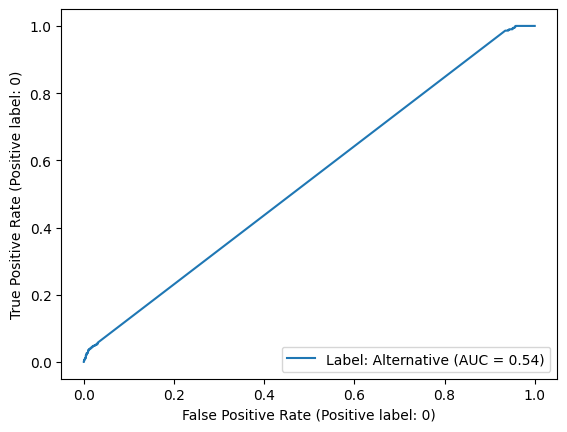

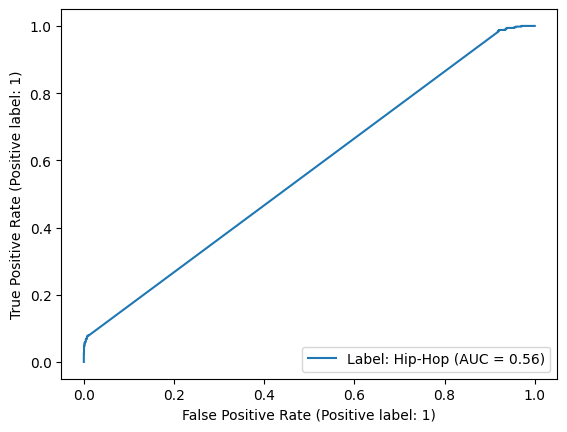

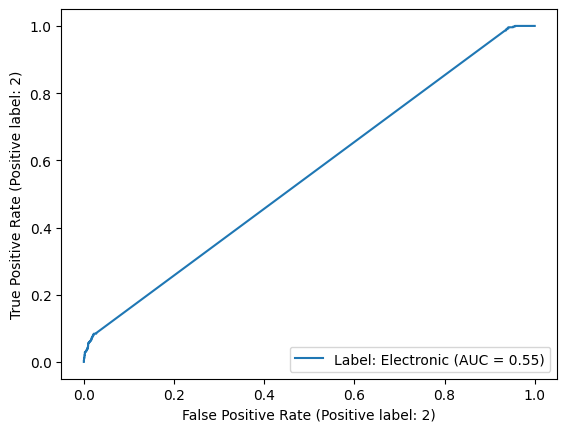

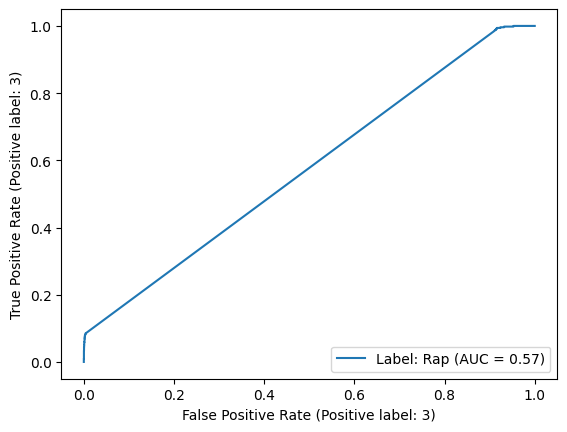

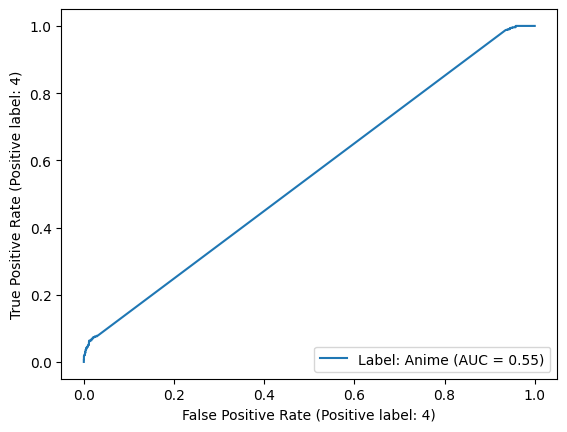

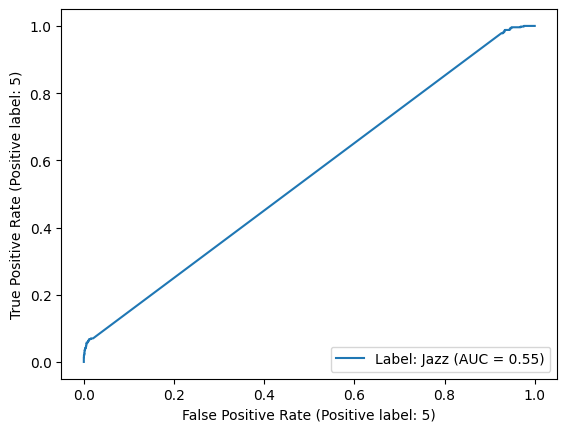

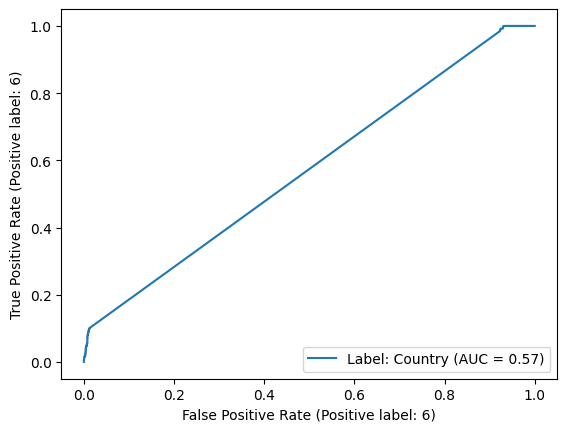

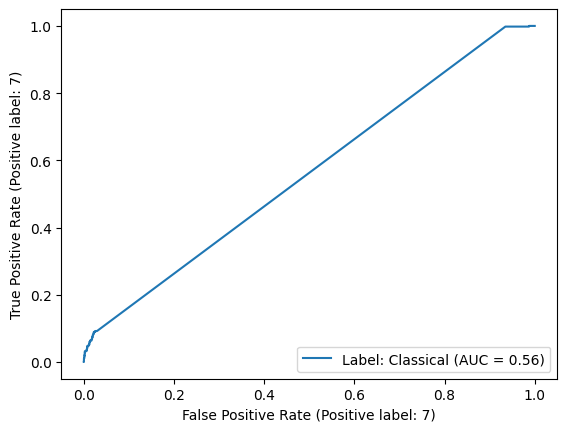

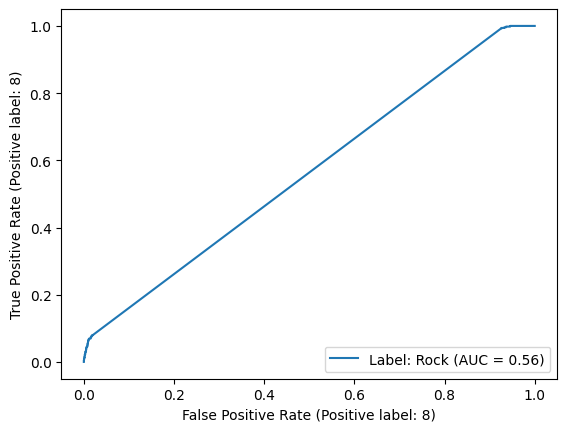

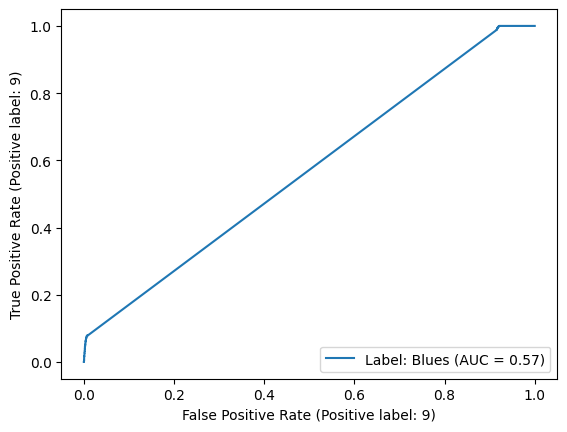

In [36]:
for i in range(numLabels):
    # For each class, get the true labels and predicted probabilities for that class
    RocCurveDisplay.from_predictions(
        y_true,
        pred_probs[:, i],
        name=f"Label: {labels[i]}",
        pos_label=i
    )

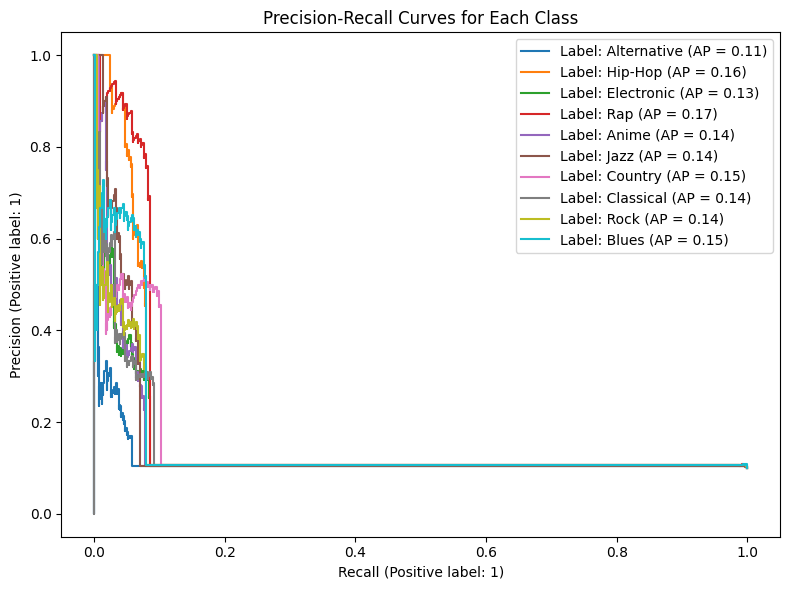

In [37]:
# plot the AUPRC of the cluster labels
y_true_bin = label_binarize(y_true, classes=range(numLabels))

# pred_probs shape should be (n_samples, numLabels)
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(numLabels):
    PrecisionRecallDisplay.from_predictions(
        y_true_bin[:, i],       # binary true labels for class i
        pred_probs[:, i],       # predicted probs for class i
        name=f"Label: {labels[i]}",
        ax=ax
    )

plt.title("Precision-Recall Curves for Each Class")
plt.legend()
plt.tight_layout()
plt.show()

Let's also train the network on our preprocessed data without the clusters so we can evaluate how the network peforms on both datasets.

In [38]:
# split our pca-imputed data to training and test splits
X_base_train, X_base_test, y_encoded_train, y_encoded_test = song_data.split_data(X_scaled, y_encoded)

# convert our pca-imputed data everything to tensors
X_base_train_tensor = torch.as_tensor(X_base_train, dtype = torch.float32)
X_base_test_tensor = torch.as_tensor(X_base_test, dtype = torch.float32)
y_encoded_train_tensor = torch.as_tensor(y_encoded_train, dtype = torch.long)
y_encoded_test_tensor = torch.as_tensor(y_encoded_test, dtype = torch.long)

print('shape of training set:', X_base_train_tensor.shape)
print('shape of test set:', X_base_test_tensor.shape)
print('shape of training labels:', y_encoded_train_tensor.shape)
print('shape of test labels:', y_encoded_test_tensor.shape)

# instantiate our model
fnn_base = FNN(X_base_train_tensor, y_encoded_train_tensor, X_base_train_tensor.shape[1], numLabels)

shape of training set: torch.Size([45000, 13])
shape of test set: torch.Size([5000, 13])
shape of training labels: torch.Size([45000])
shape of test labels: torch.Size([5000])


In [39]:
# train and eval
fnn_base._train(X_base_train_tensor, y_encoded_train_tensor)

base_loss, base_accuracy, base_y_true, base_y_pred, base_pred_probs = fnn_base._evaluate(X_base_test_tensor, y_encoded_test_tensor)

Epoch [1/200], Avg Loss: 1.4575
Epoch [2/200], Avg Loss: 1.2988
Epoch [3/200], Avg Loss: 1.2670
Epoch [4/200], Avg Loss: 1.2417
Epoch [5/200], Avg Loss: 1.2200
Epoch [6/200], Avg Loss: 1.2098
Epoch [7/200], Avg Loss: 1.2001
Epoch [8/200], Avg Loss: 1.1926
Epoch [9/200], Avg Loss: 1.1798
Epoch [10/200], Avg Loss: 1.1765
Epoch [11/200], Avg Loss: 1.1690
Epoch [12/200], Avg Loss: 1.1633
Epoch [13/200], Avg Loss: 1.1584
Epoch [14/200], Avg Loss: 1.1553
Epoch [15/200], Avg Loss: 1.1534
Epoch [16/200], Avg Loss: 1.1500
Epoch [17/200], Avg Loss: 1.1480
Epoch [18/200], Avg Loss: 1.1400
Epoch [19/200], Avg Loss: 1.1411
Epoch [20/200], Avg Loss: 1.1373
Epoch [21/200], Avg Loss: 1.1367
Epoch [22/200], Avg Loss: 1.1355
Epoch [23/200], Avg Loss: 1.1346
Epoch [24/200], Avg Loss: 1.1310
Epoch [25/200], Avg Loss: 1.1289
Epoch [26/200], Avg Loss: 1.1238
Epoch [27/200], Avg Loss: 1.1267
Epoch [28/200], Avg Loss: 1.1252
Epoch [29/200], Avg Loss: 1.1227
Epoch [30/200], Avg Loss: 1.1192
Epoch [31/200], Avg

In [40]:
# compute and print the metrics of the models evaluation
base_acc = accuracy_score(base_y_true, base_y_pred)
base_prec = precision_score(base_y_true, base_y_pred, average = 'weighted', zero_division=0)
base_recall = recall_score(base_y_true, base_y_pred, average = 'weighted', zero_division=0)
base_f1 = f1_score(base_y_true, base_y_pred, average = 'weighted', zero_division=0)
base_mcc = matthews_corrcoef(base_y_true, base_y_pred)

print('********** Forward Feed Network Metrics **********')
print(f'Base Accuracy: {base_acc}')
print(f'Base Precision: {base_prec}')
print(f'Base Recall: {base_recall}')
print(f'Base F1-Score: {base_f1}')
print(f'Base MCC Score: {base_mcc}')

********** Forward Feed Network Metrics **********
Base Accuracy: 0.5738
Base Precision: 0.5850367221590166
Base Recall: 0.5738
Base F1-Score: 0.5647320529477444
Base MCC Score: 0.530252750262004


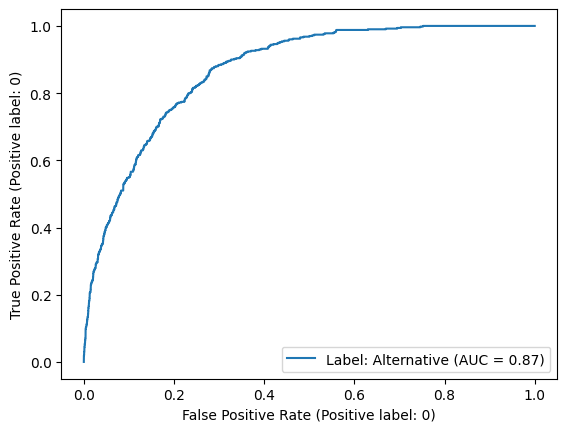

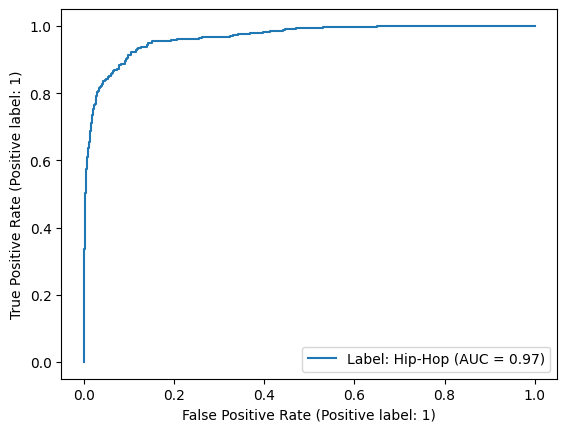

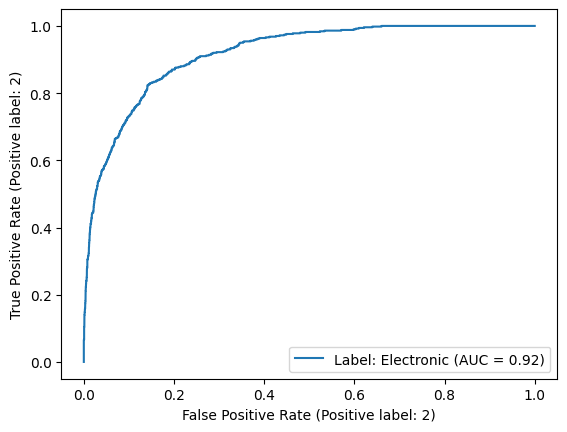

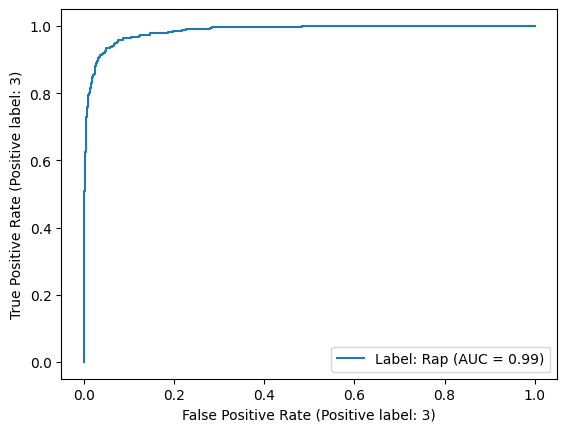

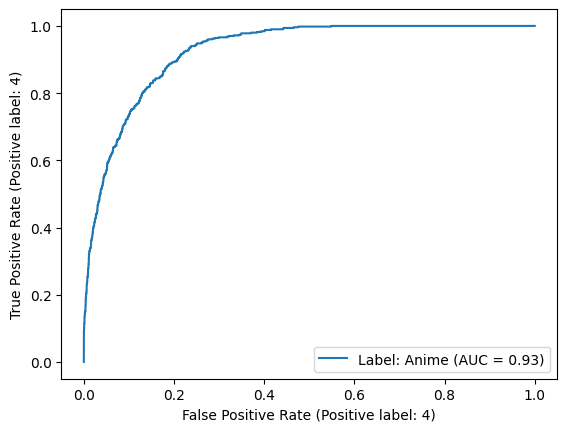

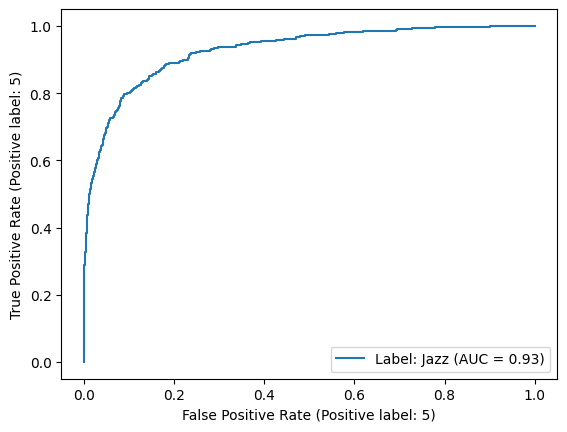

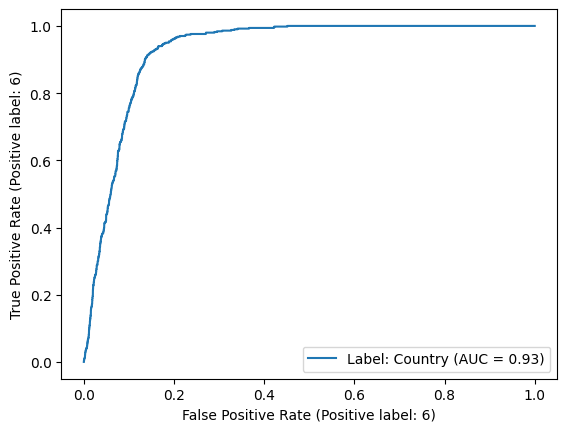

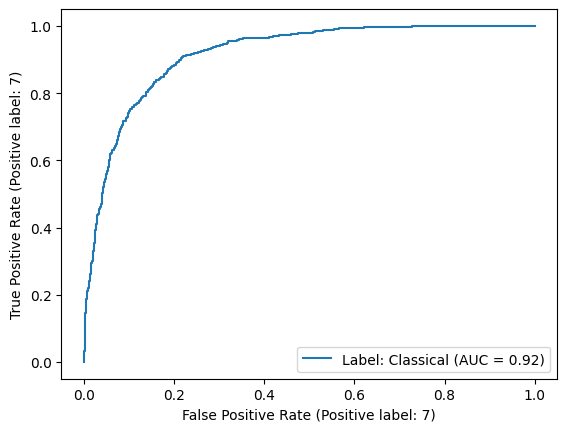

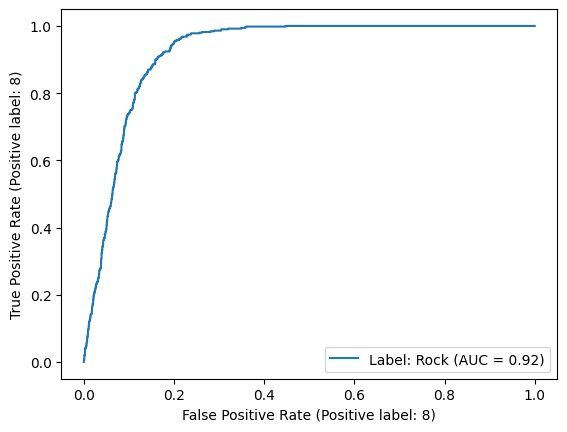

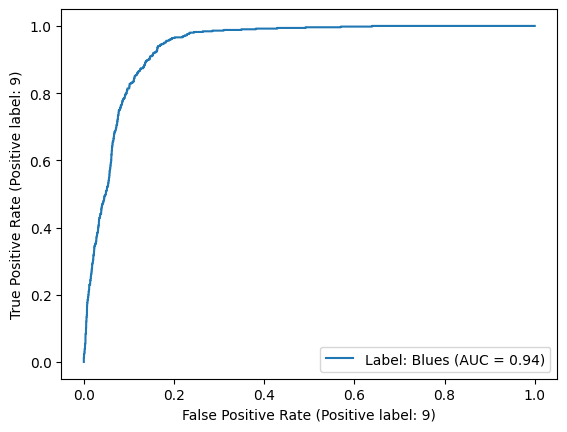

In [41]:
# plot the AUROC of the base labels
for i in range(numLabels):
    # For each class, get the true labels and predicted probabilities for that class
    RocCurveDisplay.from_predictions(
        base_y_true,
        base_pred_probs[:, i],
        name=f"Label: {labels[i]}",
        pos_label=i
    )

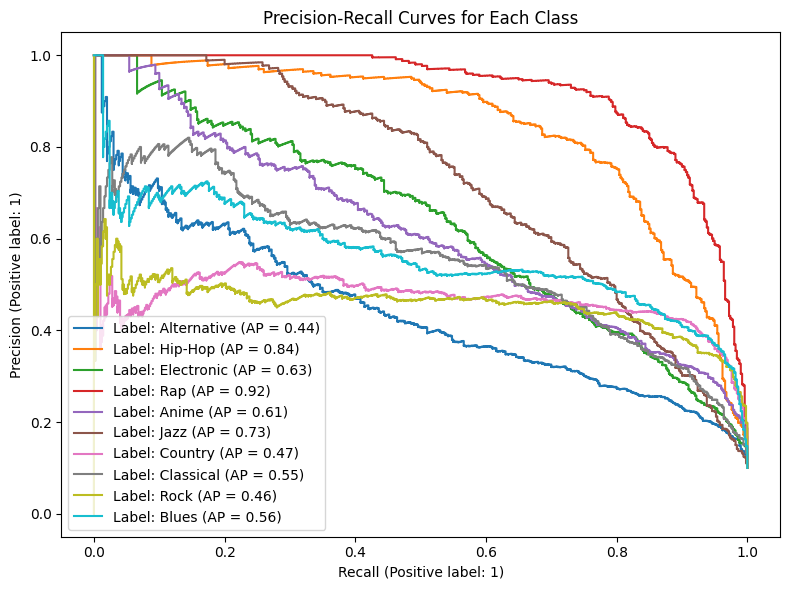

In [42]:
# plot the AUPRC of the base labels
base_y_true_bin = label_binarize(y_true, classes=range(numLabels))

# pred_probs shape should be (n_samples, numLabels)
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(numLabels):
    PrecisionRecallDisplay.from_predictions(
        base_y_true_bin[:, i],       # binary true labels for class i
        base_pred_probs[:, i],       # predicted probs for class i
        name=f"Label: {labels[i]}",
        ax=ax
    )

plt.title("Precision-Recall Curves for Each Class")
plt.legend()
plt.tight_layout()
plt.show()

Lastly, let's test the data on the labels clustered by GMM. Since PCA is a linear dimensionality reduction technique, we can see that there wasn't much performance enhancement. In fact, we can see that the performance was actually a lot worse. GMM samples from gaussian distributions, so let's see if sampling to create clusters works better than PCA.

In [43]:
print(gmm_labels)

X = X.drop('clusters', axis=1, errors='ignore')
X.head(n = 10)

[2 0 4 ... 4 2 2]


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,27.0,0.00468,0.652,-1.0,0.941,0.792000,1,0.1150,-5.201,0,0.0748,100.889000,0.759
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,5,0.1240,-7.043,0,0.0300,115.002000,0.531
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,11,0.5340,-4.617,1,0.0345,127.994000,0.333
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,4,0.1570,-4.498,1,0.2390,128.014000,0.270
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,9,0.1570,-6.266,1,0.0413,145.036000,0.323
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,5,0.2160,-10.517,0,0.0412,119.952961,0.614
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,2,0.1060,-4.294,1,0.3510,149.995000,0.230
7,43.0,0.02970,0.809,416132.0,0.706,0.903000,10,0.0635,-9.339,0,0.0484,120.008000,0.761
8,39.0,0.00299,0.509,292800.0,0.921,0.000276,8,0.1780,-3.175,0,0.2680,149.948000,0.273
9,22.0,0.00934,0.578,204800.0,0.731,0.011200,0,0.1110,-7.091,0,0.1730,139.933000,0.203


In [44]:
# add the gmm labels
X['clusters_gmm'] = gmm_labels
X.head(n = 10)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,clusters_gmm
0,27.0,0.00468,0.652,-1.0,0.941,0.792000,1,0.1150,-5.201,0,0.0748,100.889000,0.759,2
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,5,0.1240,-7.043,0,0.0300,115.002000,0.531,0
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,11,0.5340,-4.617,1,0.0345,127.994000,0.333,4
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,4,0.1570,-4.498,1,0.2390,128.014000,0.270,2
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,9,0.1570,-6.266,1,0.0413,145.036000,0.323,3
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,5,0.2160,-10.517,0,0.0412,119.952961,0.614,0
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,2,0.1060,-4.294,1,0.3510,149.995000,0.230,2
7,43.0,0.02970,0.809,416132.0,0.706,0.903000,10,0.0635,-9.339,0,0.0484,120.008000,0.761,3
8,39.0,0.00299,0.509,292800.0,0.921,0.000276,8,0.1780,-3.175,0,0.2680,149.948000,0.273,0
9,22.0,0.00934,0.578,204800.0,0.731,0.011200,0,0.1110,-7.091,0,0.1730,139.933000,0.203,0


In [45]:
# let's just explore the mean of the clusters (for exploratory purposes)
print('mean of clusters feature:', X['clusters_gmm'].mean())
print('std of clusters feature:', X['clusters_gmm'].std())

# normalize the clusters to keep consistent
gmm_clusters_normalized = song_data.z_score(X['clusters_gmm'])

# ensure clusters_normalized is a column vector
gmm_clusters_normalized = clusters_normalized.reshape(-1, 1)

X_gmm_ = np.array(X)

# append to the original array
X_gmm_ = np.hstack((X, gmm_clusters_normalized))

print('X_true:', X_gmm_)
print('Shape of X_true:', X_true.shape)

mean of clusters feature: 2.368
std of clusters feature: 1.4284595933856399
X_true: [[ 2.70000000e+01  4.68000000e-03  6.52000000e-01 ...  7.59000000e-01
   2.00000000e+00 -8.15373482e-02]
 [ 3.10000000e+01  1.27000000e-02  6.22000000e-01 ...  5.31000000e-01
   0.00000000e+00 -1.50180121e+00]
 [ 2.80000000e+01  3.06000000e-03  6.20000000e-01 ...  3.33000000e-01
   4.00000000e+00 -1.50180121e+00]
 ...
 [ 5.10000000e+01  5.97000000e-03  6.93000000e-01 ...  3.95000000e-01
   4.00000000e+00  6.28594582e-01]
 [ 6.50000000e+01  8.31000000e-02  7.82000000e-01 ...  3.54000000e-01
   2.00000000e+00 -8.15373482e-02]
 [ 6.70000000e+01  1.02000000e-01  8.62000000e-01 ...  7.65000000e-01
   2.00000000e+00 -8.15373482e-02]]
Shape of X_true: (50000, 15)


In [46]:
X_gmm_train, X_gmm_test, y_gmm_train, y_gmm_test = song_data.split_data(X_gmm_, y_encoded)

# convert to tensors
X_gmm_train_tensor = torch.as_tensor(X_gmm_train, dtype = torch.float32)
X_gmm_test_tensor = torch.as_tensor(X_gmm_test, dtype = torch.float32)
y_gmm_train_tensor = torch.as_tensor(y_gmm_train, dtype = torch.long)
y_gmm_test_tensor = torch.as_tensor(y_gmm_test, dtype = torch.long)

print('Shape of X training set:', X_gmm_train_tensor.shape)
print('Shape of X test set:', X_gmm_test_tensor.shape)
print('Shape of y training set:', y_gmm_train_tensor.shape)
print('Shape of y test set:', y_gmm_test_tensor.shape)

Shape of X training set: torch.Size([45000, 15])
Shape of X test set: torch.Size([5000, 15])
Shape of y training set: torch.Size([45000])
Shape of y test set: torch.Size([5000])


In [47]:
# instantiate the model
fnn_gmm = FNN(X_gmm_train_tensor, y_gmm_train_tensor, X_gmm_train_tensor.shape[1], numLabels)

In [48]:
# train the model on the clusters made by gmm
fnn_gmm._train(X_gmm_train_tensor, y_gmm_train_tensor)

# test the model
gmm_loss, gmm_accuracy, gmm_y_true, gmm_y_pred, gmm_pred_probs = fnn_gmm._evaluate(X_gmm_test_tensor, y_gmm_test_tensor)

Epoch [1/200], Avg Loss: 28.3712
Epoch [2/200], Avg Loss: 2.3380
Epoch [3/200], Avg Loss: 2.3171
Epoch [4/200], Avg Loss: 2.3083
Epoch [5/200], Avg Loss: 2.3037
Epoch [6/200], Avg Loss: 2.2949
Epoch [7/200], Avg Loss: 2.3087
Epoch [8/200], Avg Loss: 2.2770
Epoch [9/200], Avg Loss: 2.2769
Epoch [10/200], Avg Loss: 2.2714
Epoch [11/200], Avg Loss: 2.2706
Epoch [12/200], Avg Loss: 2.2701
Epoch [13/200], Avg Loss: 2.2661
Epoch [14/200], Avg Loss: 2.2588
Epoch [15/200], Avg Loss: 2.2589
Epoch [16/200], Avg Loss: 2.2772
Epoch [17/200], Avg Loss: 2.2512
Epoch [18/200], Avg Loss: 2.2619
Epoch [19/200], Avg Loss: 2.2420
Epoch [20/200], Avg Loss: 2.2381
Epoch [21/200], Avg Loss: 2.2380
Epoch [22/200], Avg Loss: 2.2482
Epoch [23/200], Avg Loss: 2.2411
Epoch [24/200], Avg Loss: 2.2701
Epoch [25/200], Avg Loss: 2.2508
Epoch [26/200], Avg Loss: 2.2339
Epoch [27/200], Avg Loss: 2.2491
Epoch [28/200], Avg Loss: 2.2368
Epoch [29/200], Avg Loss: 2.2326
Epoch [30/200], Avg Loss: 2.2329
Epoch [31/200], Av

In [49]:
gmm_acc = accuracy_score(gmm_y_true, gmm_y_pred)
gmm_prec = precision_score(gmm_y_true, gmm_y_pred, average = 'weighted')
gmm_recall = recall_score(gmm_y_true, gmm_y_pred, average = 'weighted')
gmm_f1 = f1_score(gmm_y_true, gmm_y_pred, average = 'weighted')
gmm_mcc = matthews_corrcoef(gmm_y_true, gmm_y_pred)

print('********** Feed Forward Network (GMM) Metrics **********')
print(f'GMM Accuracy: {gmm_acc}')
print(f'GMM Precision: {gmm_prec}')
print(f'GMM Recall: {gmm_recall}')
print(f'GMM F1-Score: {gmm_f1}')
print(f'GMM MCC: {gmm_mcc}')

********** Feed Forward Network (GMM) Metrics **********
GMM Accuracy: 0.1414
GMM Precision: 0.5095317406156722
GMM Recall: 0.1414
GMM F1-Score: 0.09863773520323767
GMM MCC: 0.10913803981098216


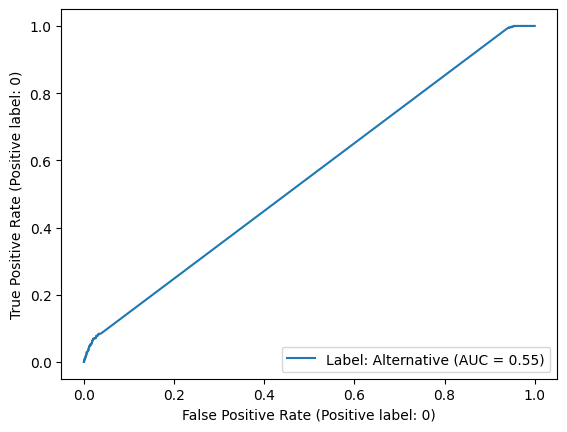

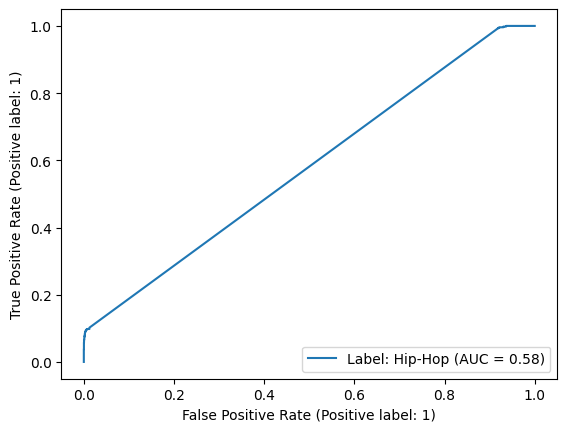

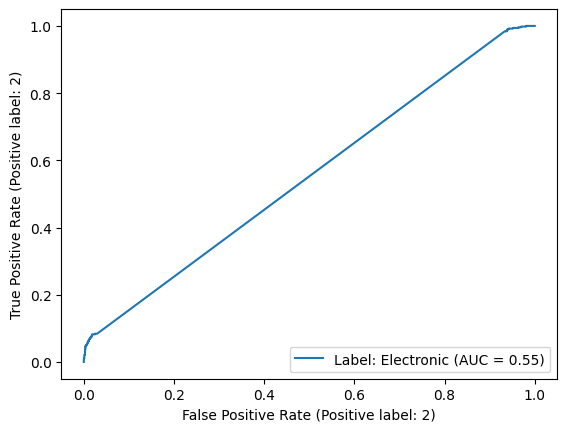

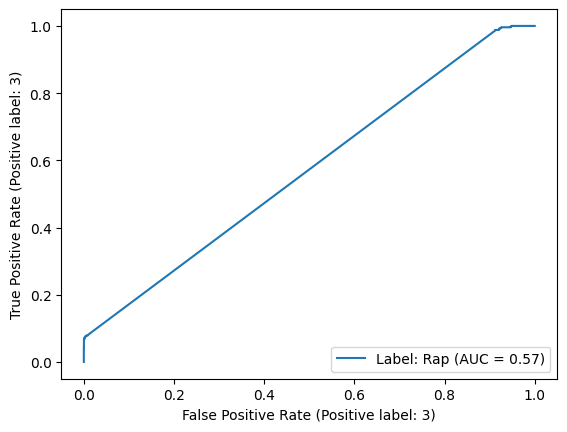

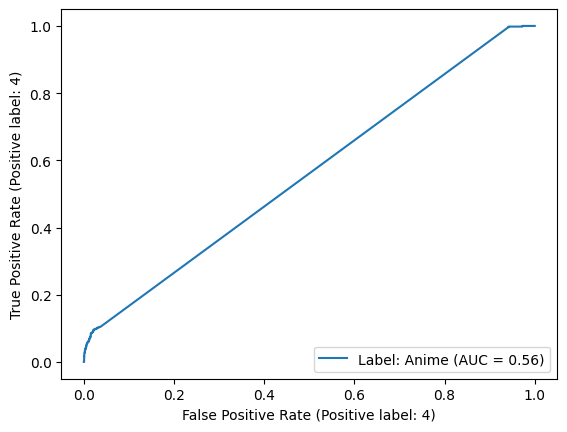

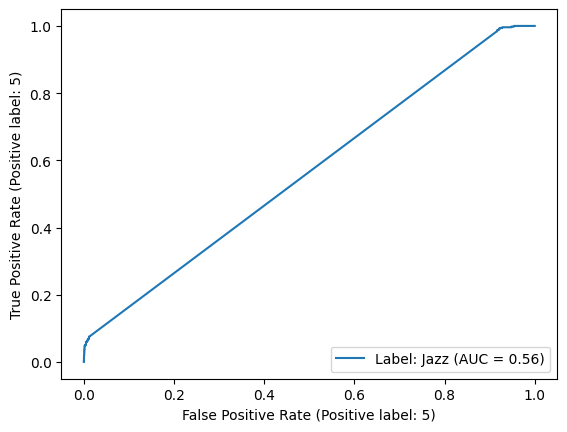

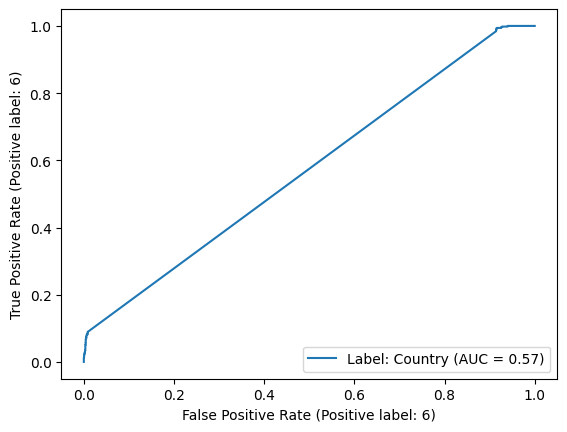

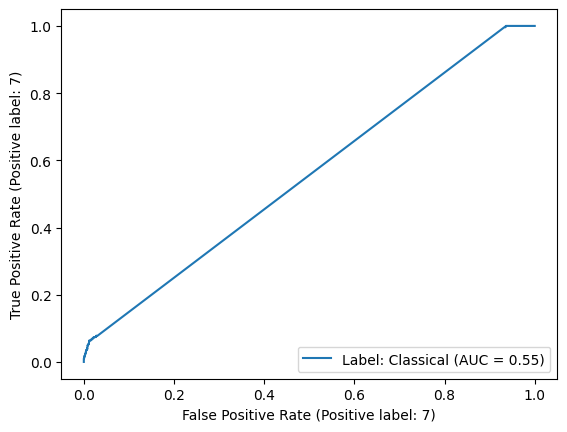

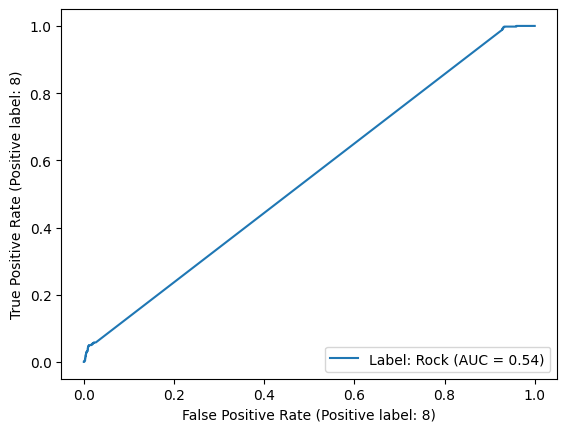

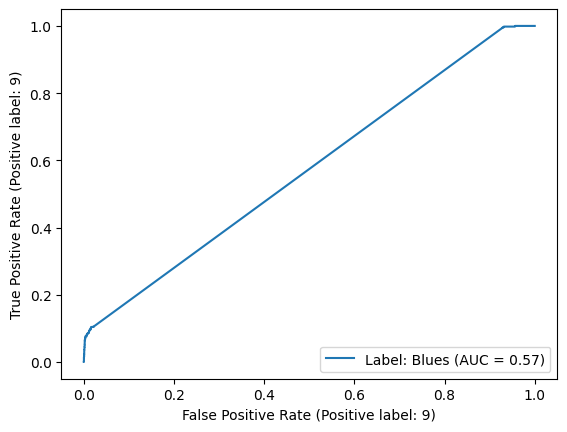

In [50]:
# plot the AUROC of the gmm-imputed labels
for i in range(numLabels):
    # For each class, get the true labels and predicted probabilities for that class
    RocCurveDisplay.from_predictions(
        gmm_y_true,
        gmm_pred_probs[:, i],
        name=f"Label: {labels[i]}",
        pos_label=i
    )

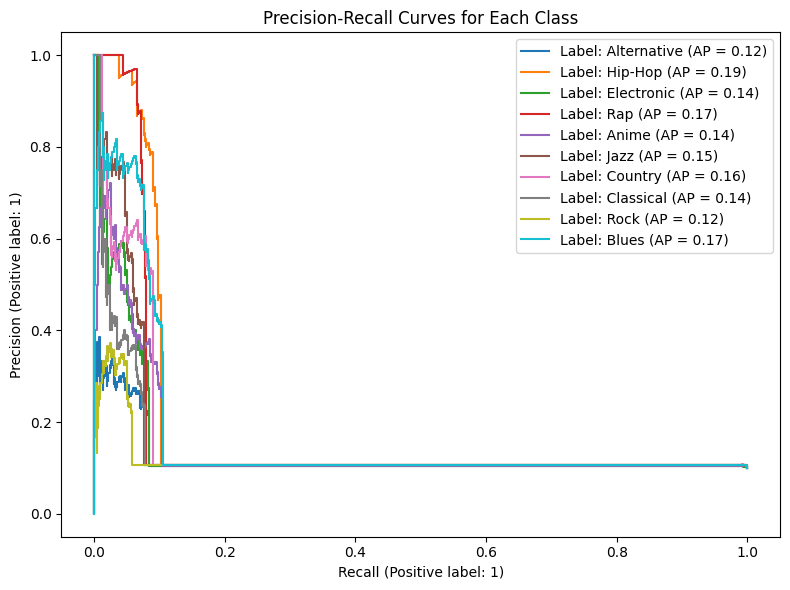

In [51]:
# plot the AUPRC of the cluster labels
gmm_y_true_bin = label_binarize(gmm_y_true, classes=range(numLabels))

# pred_probs shape should be (n_samples, numLabels)
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(numLabels):
    PrecisionRecallDisplay.from_predictions(
        gmm_y_true_bin[:, i],       # binary true labels for class i
        gmm_pred_probs[:, i],       # predicted probs for class i
        name=f"Label: {labels[i]}",
        ax=ax
    )

plt.title("Precision-Recall Curves for Each Class")
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
# since we have the label, we can use the labels we have + our reduced dataset to make a prediction
X_pca_train, X_pca_test, y_pca_train, y_pca_test = song_data.split_data(X_pca, y_encoded)

# convert to tensors
X_pca_train_tensor = torch.as_tensor(X_pca_train, dtype = torch.float32)
X_pca_test_tensor = torch.as_tensor(X_pca_test, dtype = torch.float32)
y_pca_train_tensor = torch.as_tensor(y_pca_train, dtype = torch.long)
y_pca_test_tensor = torch.as_tensor(y_pca_test, dtype = torch.long)

In [53]:
# instantiate the model, train and test
fnn_pca = FNN(X_pca_train_tensor, y_pca_train_tensor, X_pca_train_tensor.shape[1], numLabels)

# train
fnn_pca._train(X_pca_train_tensor, y_pca_train_tensor)

# test
pca_loss, pca_acc, pca_y_true, pca_y_pred, pca_pred_probs = fnn_pca._evaluate(X_pca_test_tensor, y_pca_test_tensor)

Epoch [1/200], Avg Loss: 1.8078
Epoch [2/200], Avg Loss: 1.7485
Epoch [3/200], Avg Loss: 1.7384
Epoch [4/200], Avg Loss: 1.7333
Epoch [5/200], Avg Loss: 1.7296
Epoch [6/200], Avg Loss: 1.7282
Epoch [7/200], Avg Loss: 1.7265
Epoch [8/200], Avg Loss: 1.7231
Epoch [9/200], Avg Loss: 1.7216
Epoch [10/200], Avg Loss: 1.7229
Epoch [11/200], Avg Loss: 1.7177
Epoch [12/200], Avg Loss: 1.7198
Epoch [13/200], Avg Loss: 1.7186
Epoch [14/200], Avg Loss: 1.7167
Epoch [15/200], Avg Loss: 1.7166
Epoch [16/200], Avg Loss: 1.7170
Epoch [17/200], Avg Loss: 1.7158
Epoch [18/200], Avg Loss: 1.7169
Epoch [19/200], Avg Loss: 1.7148
Epoch [20/200], Avg Loss: 1.7130
Epoch [21/200], Avg Loss: 1.7129
Epoch [22/200], Avg Loss: 1.7152
Epoch [23/200], Avg Loss: 1.7116
Epoch [24/200], Avg Loss: 1.7123
Epoch [25/200], Avg Loss: 1.7112
Epoch [26/200], Avg Loss: 1.7119
Epoch [27/200], Avg Loss: 1.7099
Epoch [28/200], Avg Loss: 1.7098
Epoch [29/200], Avg Loss: 1.7092
Epoch [30/200], Avg Loss: 1.7089
Epoch [31/200], Avg

In [54]:
pca_precision = precision_score(pca_y_true, pca_y_pred, average = 'weighted')
pca_recall = recall_score(pca_y_true, pca_y_pred, average = 'weighted')
pca_f1 = f1_score(pca_y_true, pca_y_pred, average = 'weighted')
pca_mcc = matthews_corrcoef(pca_y_true, pca_y_pred)

print('********** Feed Forward Network (PCA w/ Labels) Metrics **********')
print(f'PCA Accuracy: {pca_acc}')
print(f'PCA Precision: {pca_precision}')
print(f'PCA Recall: {pca_recall}')
print(f'PCA F1: {pca_f1}')
print(f'PCA MCC: {pca_mcc}')

********** Feed Forward Network (PCA w/ Labels) Metrics **********
PCA Accuracy: 0.3592
PCA Precision: 0.3447815048564323
PCA Recall: 0.3592
PCA F1: 0.3300644587596533
PCA MCC: 0.2928699139528129


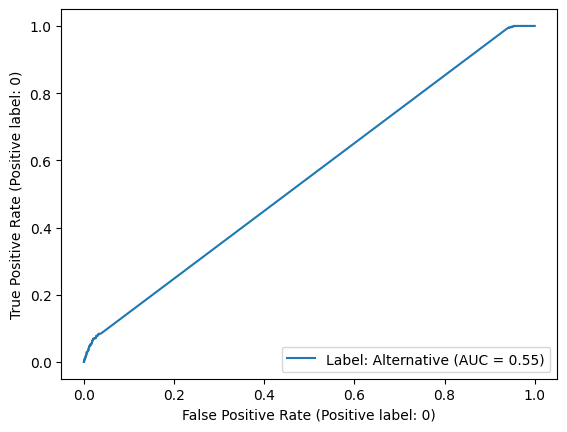

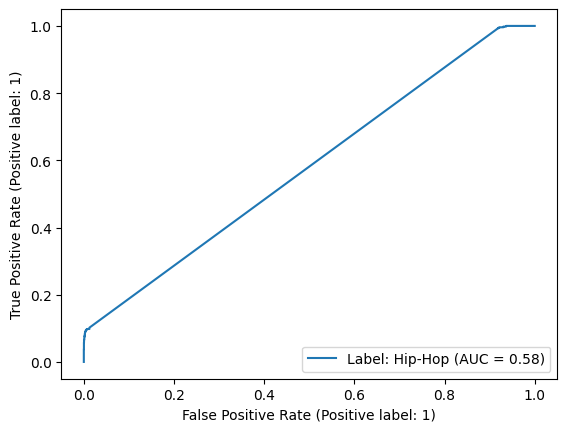

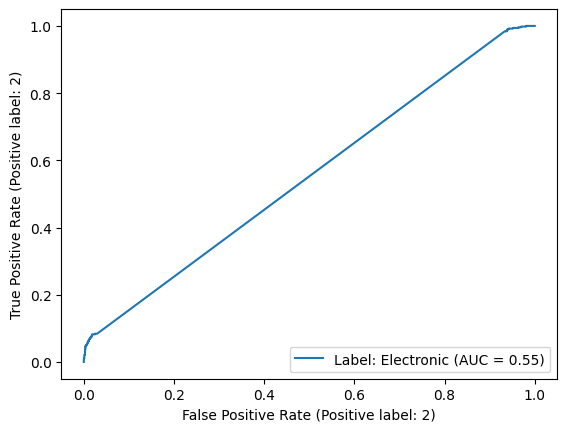

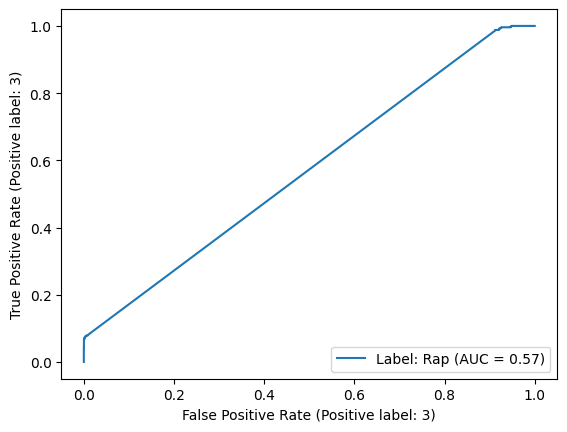

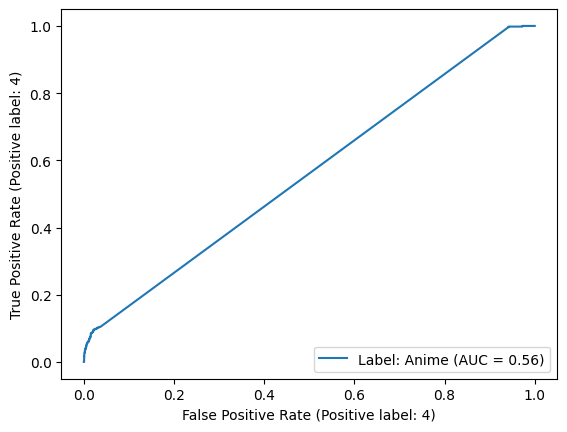

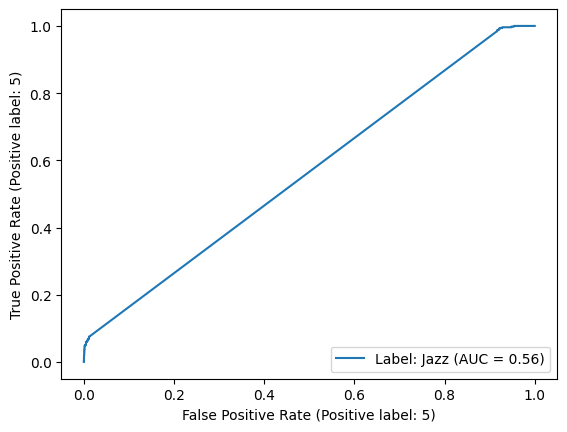

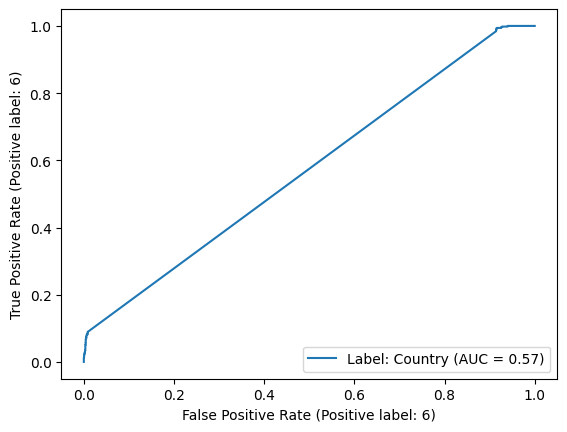

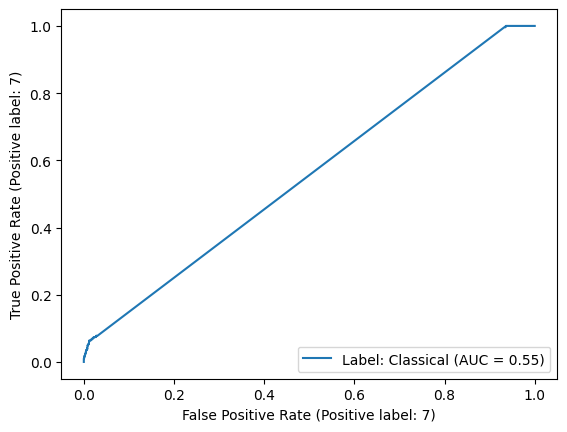

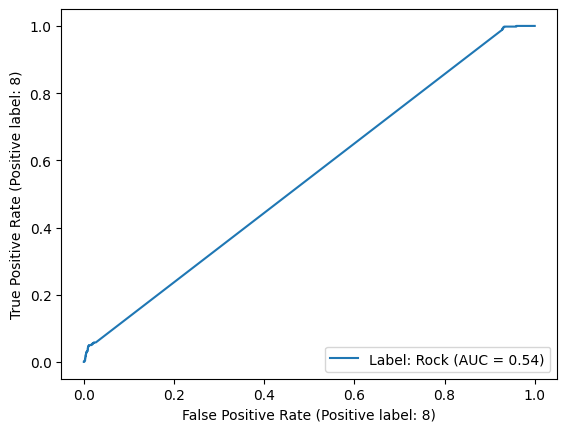

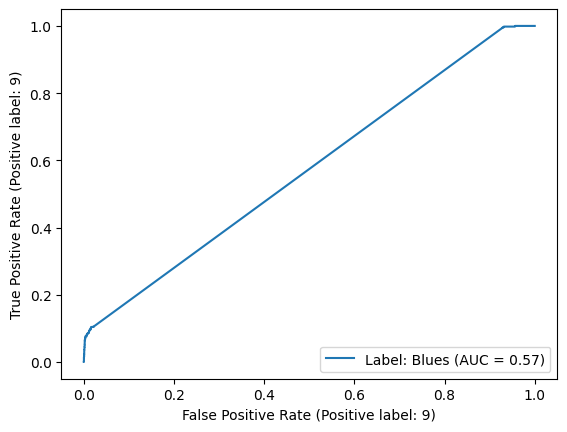

In [55]:
# plot the AUROC of the gmm-imputed labels
for i in range(numLabels):
    # For each class, get the true labels and predicted probabilities for that class
    RocCurveDisplay.from_predictions(
        gmm_y_true,
        gmm_pred_probs[:, i],
        name=f"Label: {labels[i]}",
        pos_label=i
    )

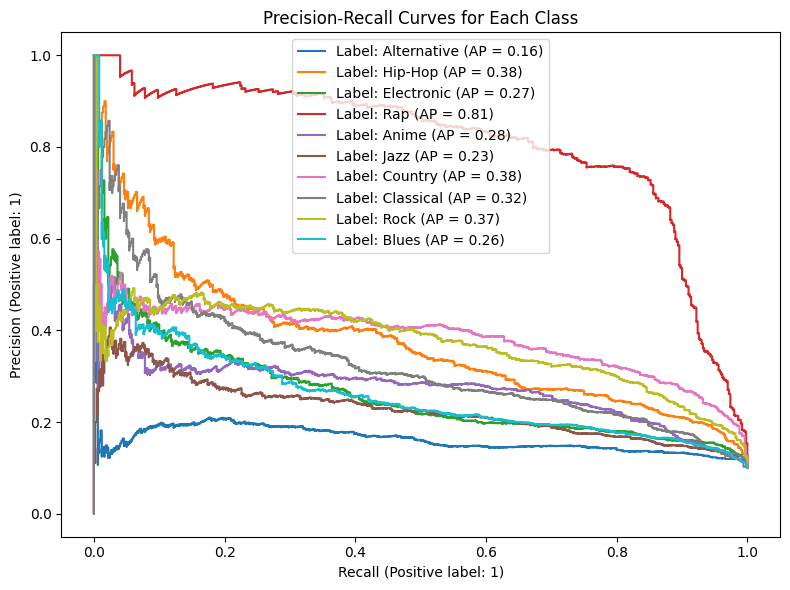

In [56]:
# plot the AUPRC of the cluster labels
pca_y_true_bin = label_binarize(pca_y_true, classes=range(numLabels))

# pred_probs shape should be (n_samples, numLabels)
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(numLabels):
    PrecisionRecallDisplay.from_predictions(
        pca_y_true_bin[:, i],       # binary true labels for class i
        pca_pred_probs[:, i],       # predicted probs for class i
        name=f"Label: {labels[i]}",
        ax=ax
    )

plt.title("Precision-Recall Curves for Each Class")
plt.legend()
plt.tight_layout()
plt.show()